In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

In [11]:
# Phase 1.1: Load Clean Data from Kaggle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# --- IMPORTANT: Please update this path ---
# The path MUST end with a slash '/'
KAGGLE_DATASET_PATH = '/kaggle/input/stock-data-for-kaggle/'
FILE_NAME = 'stock_data_2010_2025.csv'
full_path = KAGGLE_DATASET_PATH + FILE_NAME

try:
    df = pd.read_csv(full_path, header=[0, 1], index_col=0, parse_dates=True)
    print("--- Data loaded successfully into main DataFrame 'df' ---")
    print("\nFirst 5 rows of the loaded DataFrame:")
    print(df.head())
except Exception as e:
    print(f"An error occurred: {e}")
    raise


--- Data loaded successfully into main DataFrame 'df' ---

First 5 rows of the loaded DataFrame:
Price          Close                                    High          \
Ticker          AAPL    AMZN       GOOG       MSFT      AAPL    AMZN   
Date                                                                   
2010-01-04  6.424605  6.6950  15.504141  23.173346  6.439315  6.8305   
2010-01-05  6.435712  6.7345  15.435864  23.180832  6.472036  6.7740   
2010-01-06  6.333344  6.6125  15.046746  23.038574  6.461229  6.7365   
2010-01-07  6.321636  6.5000  14.696465  22.798977  6.364265  6.6160   
2010-01-08  6.363664  6.6760  14.892386  22.956213  6.364264  6.6840   

Price                                  Low                                \
Ticker           GOOG       MSFT      AAPL    AMZN       GOOG       MSFT   
Date                                                                       
2010-01-04  15.572415  23.285656  6.375672  6.6570  15.442050  22.903801   
2010-01-05  15.531103 

In [18]:
print("--- 1. Concise Summary of the DataFrame ---")
df.info(verbose=True)

print("\n" + "="*80 + "\n")

print("--- 2. Descriptive Statistics for All Columns ---")
print(df.describe())


--- 1. Concise Summary of the DataFrame ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2010-01-04 to 2025-09-16
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3950 non-null   float64
 1   (Close, AMZN)   3950 non-null   float64
 2   (Close, GOOG)   3950 non-null   float64
 3   (Close, MSFT)   3950 non-null   float64
 4   (High, AAPL)    3950 non-null   float64
 5   (High, AMZN)    3950 non-null   float64
 6   (High, GOOG)    3950 non-null   float64
 7   (High, MSFT)    3950 non-null   float64
 8   (Low, AAPL)     3950 non-null   float64
 9   (Low, AMZN)     3950 non-null   float64
 10  (Low, GOOG)     3950 non-null   float64
 11  (Low, MSFT)     3950 non-null   float64
 12  (Open, AAPL)    3950 non-null   float64
 13  (Open, AMZN)    3950 non-null   float64
 14  (Open, GOOG)    3950 non-null   float64
 15  (Open, MSFT)    3950 non-null   float64
 16  (Volume, AAPL)  

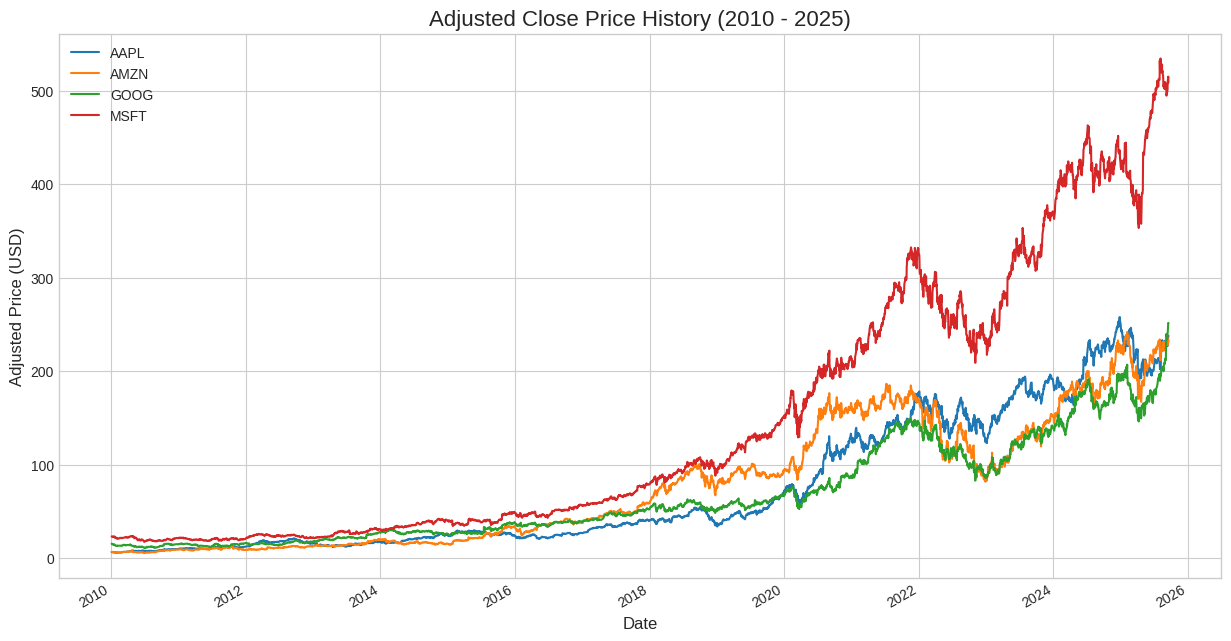

In [19]:
# Phase 1.2: Price History Analysis

close_prices = df['Close']

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 8))

close_prices.plot(ax=plt.gca())

plt.title('Adjusted Close Price History (2010 - 2025)', fontsize=16)
plt.ylabel('Adjusted Price (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(close_prices.columns, loc='upper left')
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

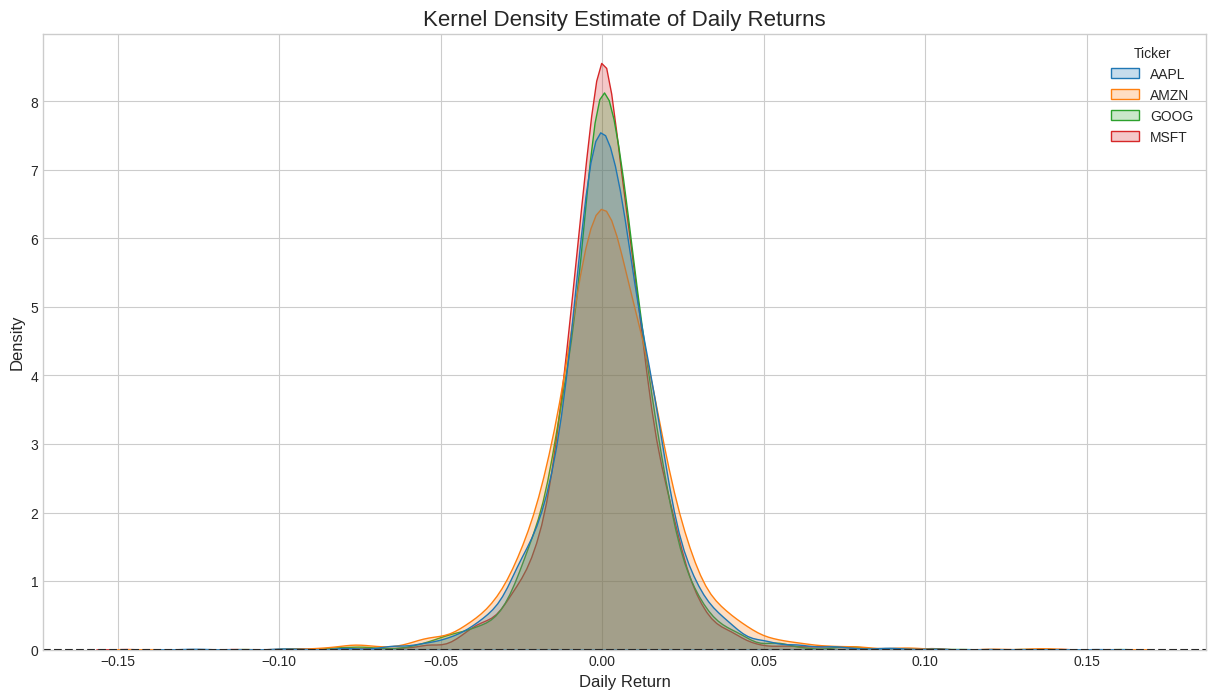

In [20]:
# Phase 1.4: Daily Return Analysis

close_prices = df['Close']
daily_returns = close_prices.pct_change()

plt.figure(figsize=(15, 8))
sns.kdeplot(data=daily_returns, fill=True)

plt.title('Kernel Density Estimate of Daily Returns', fontsize=16)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.show()


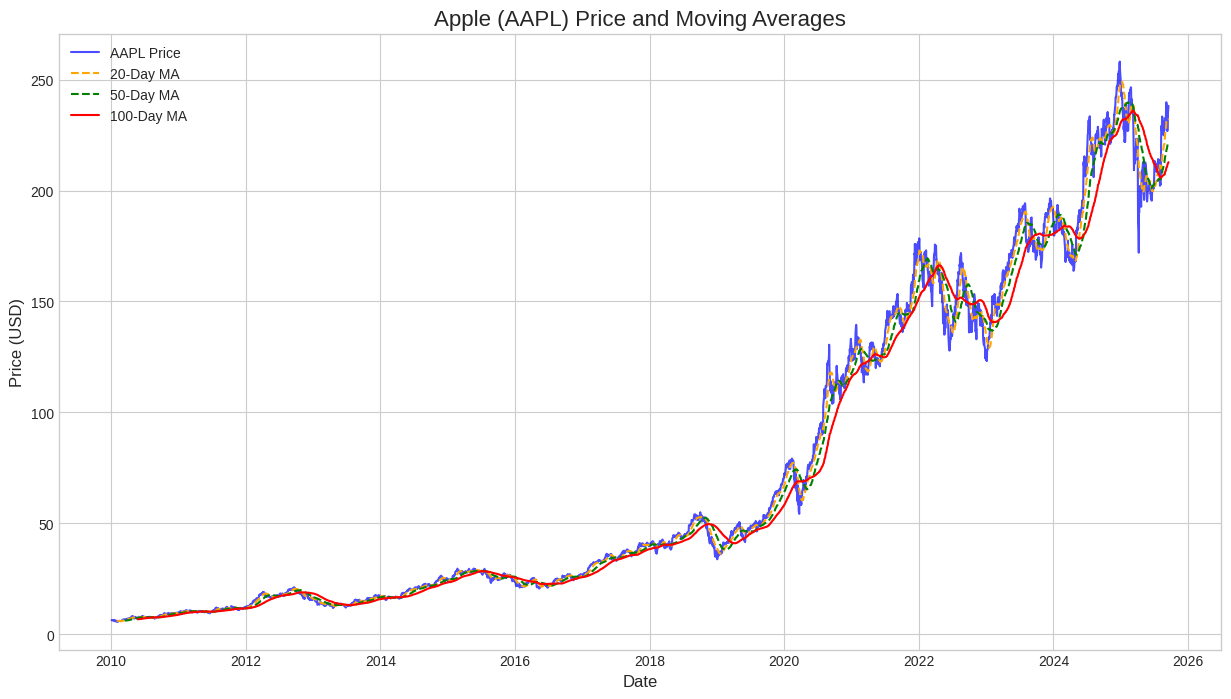

In [21]:
# Phase 1.5: Moving Average Analysis for a Single Stock (AAPL)

aapl_close = df['Close']['AAPL']

ma_20 = aapl_close.rolling(window=20).mean()
ma_50 = aapl_close.rolling(window=50).mean()
ma_100 = aapl_close.rolling(window=100).mean()

plt.figure(figsize=(15, 8))

plt.plot(aapl_close.index, aapl_close, label='AAPL Price', color='blue', alpha=0.7)
plt.plot(ma_20.index, ma_20, label='20-Day MA', color='orange', linestyle='--')
plt.plot(ma_50.index, ma_50, label='50-Day MA', color='green', linestyle='--')
plt.plot(ma_100.index, ma_100, label='100-Day MA', color='red', linestyle='-')

plt.title('Apple (AAPL) Price and Moving Averages', fontsize=16)
plt.ylabel('Price (USD)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend()
plt.show()


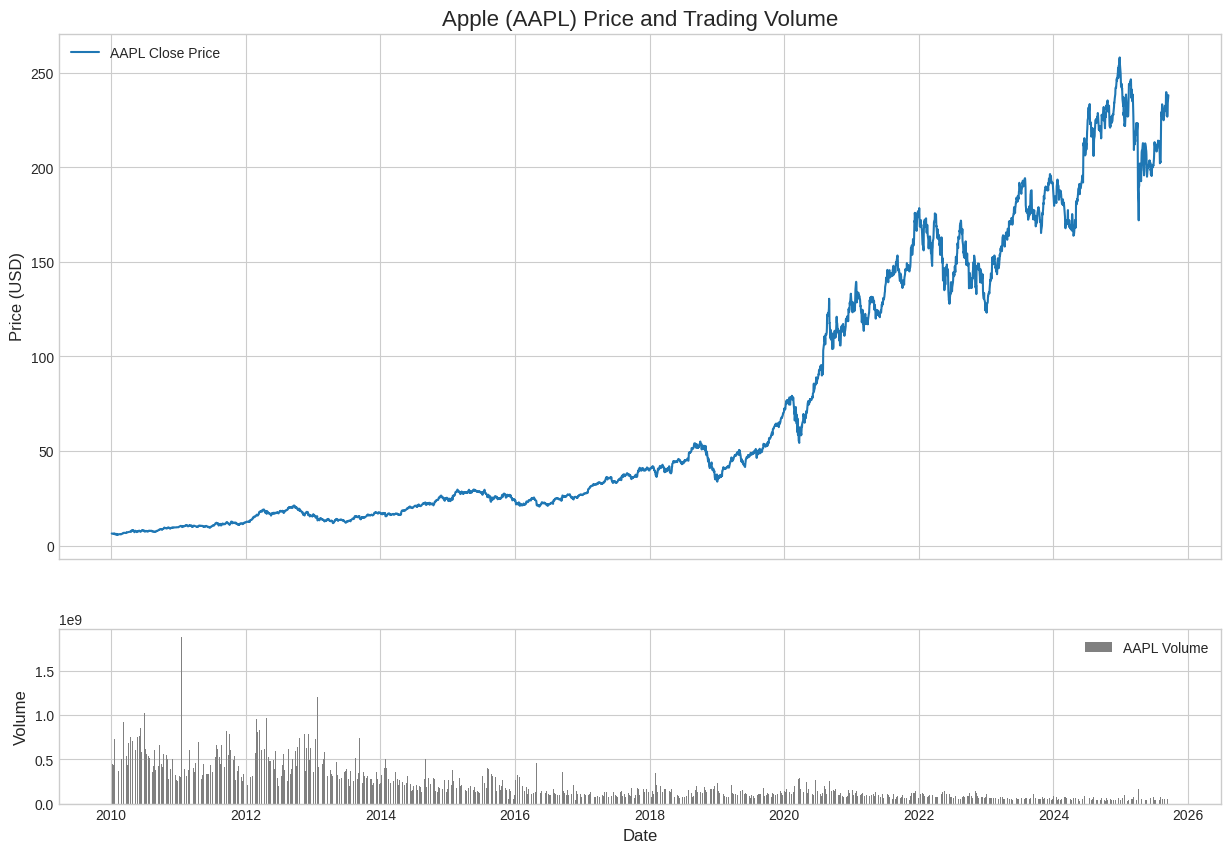

In [33]:
trading_volume = df['Volume']


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})


ax1.plot(df.index, df['Close']['AAPL'], label='AAPL Close Price')
ax1.set_title('Apple (AAPL) Price and Trading Volume', fontsize=16)
ax1.set_ylabel('Price (USD)', fontsize=12)
ax1.legend()
ax1.grid(True)


ax2.bar(df.index, df['Volume']['AAPL'], label='AAPL Volume', color='grey')
ax2.set_ylabel('Volume', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.show()


--- Correlation Matrix of Daily Returns ---
Ticker      AAPL      AMZN      GOOG      MSFT
Ticker                                        
AAPL    1.000000  0.488633  0.545966  0.584409
AMZN    0.488633  1.000000  0.597399  0.574860
GOOG    0.545966  0.597399  1.000000  0.629011
MSFT    0.584409  0.574860  0.629011  1.000000


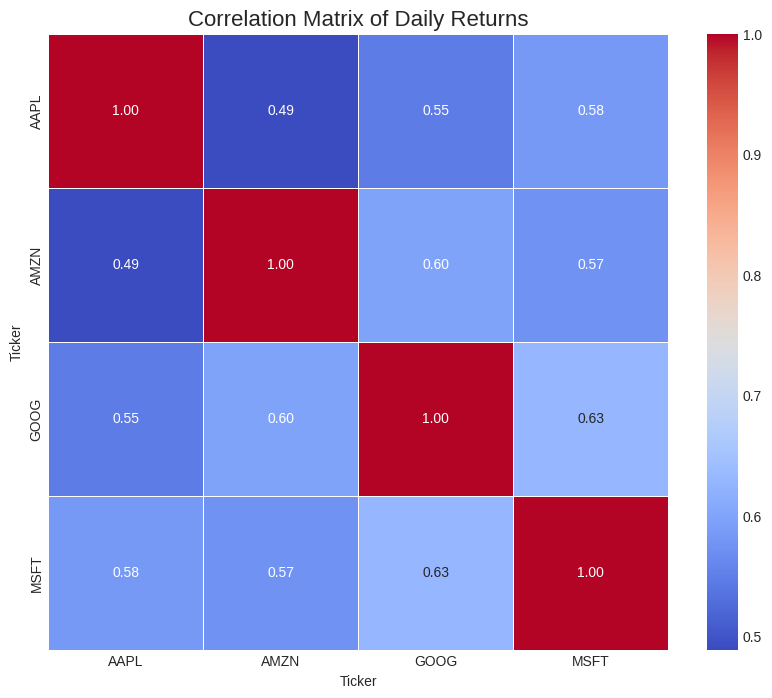

In [22]:
# Phase 1.6: Correlation Analysis

close_prices = df['Close']
daily_returns = close_prices.pct_change()
correlation_matrix = daily_returns.corr()

print("--- Correlation Matrix of Daily Returns ---")
print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.show()


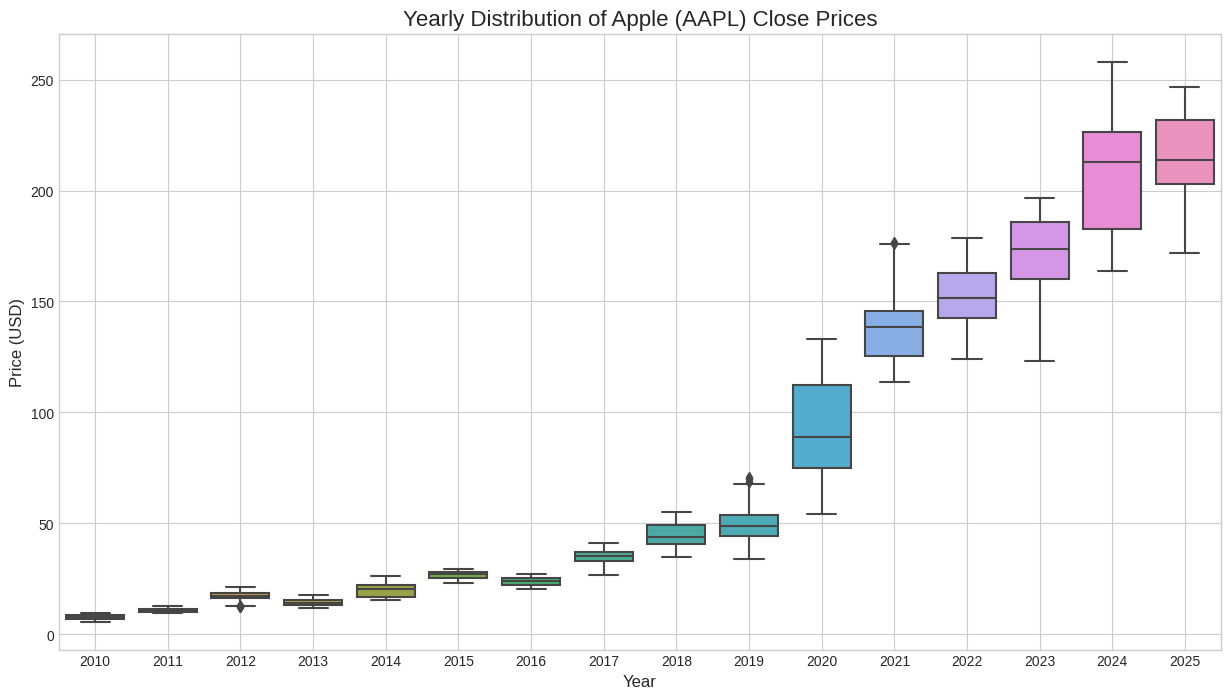

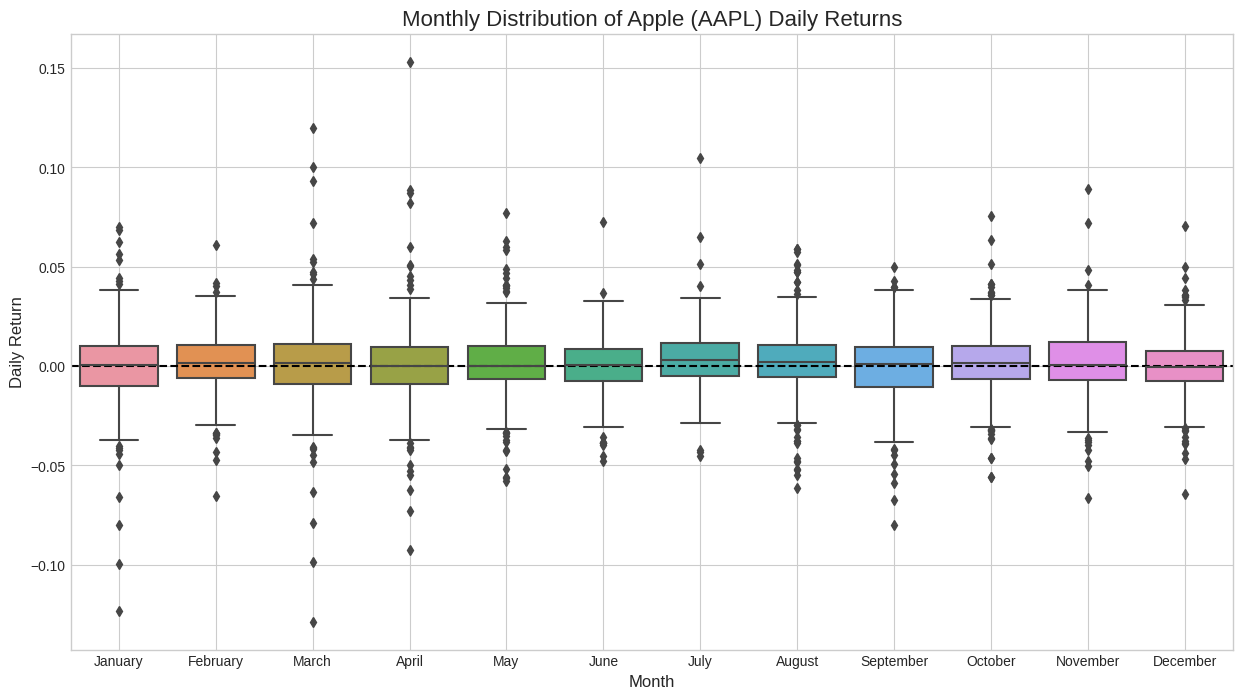

In [36]:
# Phase 1.7: Seasonal Distribution Analysis
# This analysis helps us understand if there are any seasonal patterns or trends
# in the stock's price and returns on a yearly or monthly basis.

# --- Yearly Distribution of Close Prices ---


df_box = df.copy()
df_box['Year'] = df_box.index.year
plt.figure(figsize=(15, 8))
sns.boxplot(x=df_box['Year'], y=df['Close']['AAPL'])
plt.title('Yearly Distribution of Apple (AAPL) Close Prices', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True)
plt.show()


# --- Monthly Distribution of Daily Returns ---

daily_returns = df['Close']['AAPL'].pct_change().dropna()
monthly_returns_df = daily_returns.to_frame(name='returns')
monthly_returns_df['Month'] = monthly_returns_df.index.strftime('%B') # Get month name
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Create the box plot for monthly daily returns
plt.figure(figsize=(15, 8))
sns.boxplot(x='Month', y='returns', data=monthly_returns_df, order=month_order)

# Set plot titles and labels
plt.title('Monthly Distribution of Apple (AAPL) Daily Returns', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Daily Return', fontsize=12)
plt.axhline(0, color='black', linestyle='--')
plt.grid(True)
plt.show()


In [23]:
# Phase 2.1: Isolate and Scale Data for the LSTM Model (AAPL)

aapl_df = df.loc[:, [('Close', 'AAPL'), ('Volume', 'AAPL')]]
aapl_df.columns = ['Close', 'Volume']

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(aapl_df)

print("--- Original AAPL Data (first 5 rows) ---")
print(aapl_df.head())

print("\n--- Scaled Data (first 5 rows) ---")
print(scaled_data[:5])

training_data_len = int(np.ceil(len(scaled_data) * .8))
print(f"\nTotal data length: {len(scaled_data)}")
print(f"Training data length: {training_data_len}")
print(f"Testing data length: {len(scaled_data) - training_data_len}")


--- Original AAPL Data (first 5 rows) ---
               Close     Volume
Date                           
2010-01-04  6.424605  493729600
2010-01-05  6.435712  601904800
2010-01-06  6.333344  552160000
2010-01-07  6.321636  477131200
2010-01-08  6.363664  447610800

--- Scaled Data (first 5 rows) ---
[[0.00261253 0.2532588 ]
 [0.00265655 0.31148753]
 [0.00225087 0.28471081]
 [0.00220447 0.24432418]
 [0.00237102 0.22843389]]

Total data length: 3950
Training data length: 3160
Testing data length: 790


In [24]:
# Phase 2.2: Create Training and Testing Sequences

train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, :])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = scaled_data[training_data_len:, 0]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)

print("--- Shape of Training Data ---")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\n--- Shape of Testing Data ---")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


--- Shape of Training Data ---
x_train shape: (3100, 60, 2)
y_train shape: (3100,)

--- Shape of Testing Data ---
x_test shape: (790, 60, 2)
y_test shape: (790,)


In [26]:
# Phase 3.1 (Revised): Build the LSTM Model using the Functional API

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, AdditiveAttention, Multiply
from tensorflow.keras.models import Model

# Define the input layer
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

# First LSTM layer
lstm_out = LSTM(units=128, return_sequences=True)(inputs)
lstm_out = Dropout(0.2)(lstm_out)

# Second LSTM layer
lstm_out = LSTM(units=64, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.2)(lstm_out)

# Attention mechanism
attention_out = AdditiveAttention(name='attention_weight')([lstm_out, lstm_out])
multiplied_out = Multiply()([lstm_out, attention_out])

# Flattening the output for the Dense layer
# We will use a layer that can process sequences, like GlobalAveragePooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
avg_pool_out = GlobalAveragePooling1D()(multiplied_out)

# Dense layers for final prediction
dense_out = Dense(64, activation='relu')(avg_pool_out)
dense_out = Dropout(0.2)(dense_out)
outputs = Dense(1)(dense_out)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 60, 128)   │     67,072 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 128)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 60, 64)    │     49,408 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 64)    │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weight    │ (None, 60, 64)    │         64 │ dropout_3[0][0],  │
│ (AdditiveAttention) │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 60, 64)    │          0 │ dropout_3[0][0],  │
│                     │                   │            │ attention_weight… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 120,769 (471.75 KB)

 Trainable params: 120,769 (471.75 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Phase 3.2: Train the LSTM Model

print("--- Starting Model Training ---")

history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_split=0.2
)

print("\n--- Model Training Finished ---")


--- Starting Model Training ---
Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - loss: 2.7754e-04 - val_loss: 0.0173
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 2.5127e-04 - val_loss: 0.0035
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - loss: 2.4582e-04 - val_loss: 0.0048
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - loss: 2.3587e-04 - val_loss: 0.0236
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - loss: 2.2091e-04 - val_loss: 0.0259
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 1.6573e-04 - val_loss: 0.0265
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - loss: 1.8851e-04 - val_loss: 0.0174
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - loss: 1.4956e-04 - val_loss: 0.0253
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 1.5798e-04 - val_loss: 0.0424
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss:

--- Enhanced Model Evaluation ---
Root Mean Squared Error (RMSE): 19.93 USD
Mean Absolute Error (MAE): 15.69 USD
Mean Absolute Percentage Error (MAPE): 7.84 %


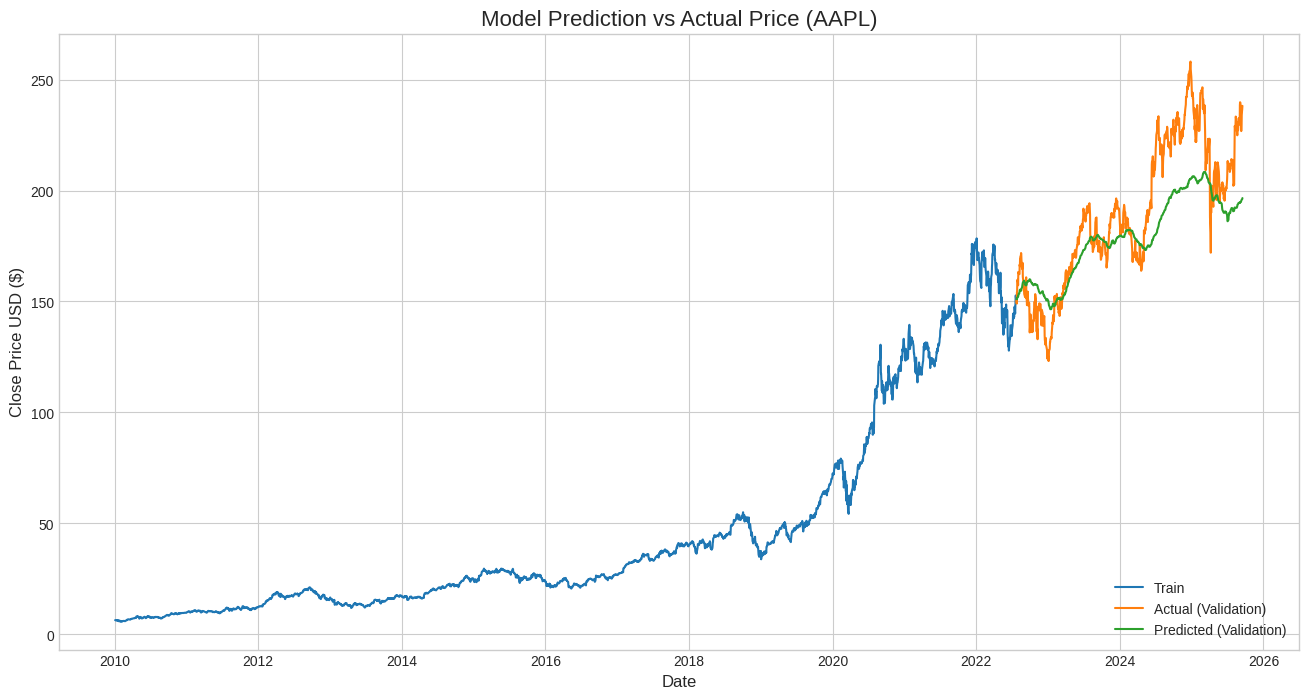

In [29]:
# Phase 5.1: Enhanced Model Evaluation with Multiple Metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_prices, predictions))

# 2. Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(actual_prices, predictions)

# 3. Calculate MAPE (Mean Absolute Percentage Error)
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = calculate_mape(actual_prices, predictions)

print('--- Enhanced Model Evaluation ---')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f} USD')
print(f'Mean Absolute Error (MAE): {mae:.2f} USD')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f} %')

# Plotting the results (same as before)
train = aapl_df[:training_data_len]
validation = aapl_df[training_data_len:].copy()
validation['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model Prediction vs Actual Price (AAPL)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['Close'])
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Actual (Validation)', 'Predicted (Validation)'], loc='lower right')
plt.show()
